In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer
from src.analysis.features import get_historical_features, get_stock_metadata
from src.db.main import DatabaseApi
from utils.tickers import get_snp500_tickers

In [2]:
db = DatabaseApi()
stocks = get_snp500_tickers()

data = db.request(stocks).dropna(axis=1, how='all')
data.head()

MMM                                      \
                                 Open        High         Low       Close   
2022-03-29 00:00:00-04:00  151.000000  152.919998  150.039993  152.080002   
2022-03-30 00:00:00-04:00  151.330002  153.259995  150.770004  151.429993   
2022-03-31 00:00:00-04:00  150.449997  151.250000  148.800003  148.880005   
2022-04-01 00:00:00-04:00  149.630005  149.860001  146.850006  149.690002   
2022-04-04 00:00:00-04:00  149.059998  150.009995  146.080002  149.529999   

                                                        AOS             \
                            Adj Close     Volume       Open       High   
2022-03-29 00:00:00-04:00  145.379379  2693200.0  67.370003  67.720001   
2022-03-30 00:00:00-04:00  144.758011  2395100.0  67.120003  67.209999   
2022-03-31 00:00:00-04:00  142.320389  3193800.0  66.239998  66.720001   
2022-04-01 00:00:00-04:00  143.094696  2196400.0  64.620003  65.910004   
2022-04-04 00:00:00-04:00  142.941727  2631800.0  65.820000  67.320000   

                                                 ...       ZION             \
                                 Low      Close  ...        Low      Close   
2022-03-29 00:00:00-04:00  66.750000  67.480003  ...  69.290001  69.739998   
2022-03-30 00:00:00-04:00  65.879997  66.250000  ...  66.260002  67.370003   
2022-03-31 00:00:00-04:00  63.849998  63.889999  ...  65.529999  65.559998   
2022-04-01 00:00:00-04:00  63.689999  65.879997  ...  64.269997  64.300003   
2022-04-04 00:00:00-04:00  65.339996  67.059998  ...  62.770000  64.099998   

                                                        ZTS              \
                           Adj Close     Volume        Open        High   
2022-03-29 00:00:00-04:00  67.689415  1257700.0  191.889999  194.600006   
2022-03-30 00:00:00-04:00  65.389099  1257100.0  191.820007  192.779999   
2022-03-31 00:00:00-04:00  63.632324  1578300.0  192.449997  194.899994   
2022-04-01 00:00:00-04:00  62.409374  2479500.0  188.770004  191.550003   
2022-04-04 00:00:00-04:00  62.215248  1220400.0  191.139999  191.979996   

                                                                          
                                  Low       Close   Adj Close     Volume  
2022-03-29 00:00:00-04:00  191.740005  192.279999  190.737900  2557400.0  
2022-03-30 00:00:00-04:00  189.580002  191.320007  189.785614  2612700.0  
2022-03-31 00:00:00-04:00  188.490005  188.589996  187.077499  2477600.0  
2022-04-01 00:00:00-04:00  186.699997  191.110001  189.577286  1831400.0  
2022-04-04 00:00:00-04:00  187.179993  188.740005  187.226303  2603600.0  

[5 rows x 3006 columns]

In [3]:
historical_features = get_historical_features(data).sort_index()
historical_features.head()

,volatility,avg_volume,price_range
A,0.015168,1.248796e+06,3.315686
AAL,0.025549,2.580241e+07,0.512353
AAP,0.016310,1.064729e+06,3.373726
AAPL,0.017078,7.269024e+07,3.464606
ABBV,0.011400,5.862084e+06,2.612157


In [4]:
metadata = get_stock_metadata(stocks)
metadata.head()

,language,region,quoteType,typeDisp,quoteSourceName,triggerable,customPriceAlertConfidence,currency,marketState,regularMarketOpen,...,askSize,fullExchangeName,financialCurrency,regularMarketChangePercent,regularMarketPrice,displayName,price,prevName,nameChangeDate,ipoExpectedDate
A,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,139.19,...,14,NYSE,USD,-2.310510,135.72,Agilent,135.72,NaN,NaN,NaN
AAL,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,15.98,...,22,NasdaqGS,USD,-2.644837,15.46,American Airlines,15.46,NaN,NaN,NaN
AAP,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,129.12,...,9,NYSE,USD,-1.378733,128.04,Advance Auto Parts,128.04,NaN,NaN,NaN
AAPL,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,150.21,...,11,NasdaqGS,USD,-1.387872,148.50,Apple,148.50,NaN,NaN,NaN
ABBV,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,147.84,...,8,NYSE,USD,1.601629,149.71,AbbVie,149.71,NaN,NaN,NaN


In [5]:
metadata_features_cols = ["trailingAnnualDividendRate", "trailingPE", "trailingAnnualDividendYield", "epsTrailingTwelveMonths", "marketCap", "priceToBook"]

metadata_features = metadata.copy()
metadata_features = metadata_features[metadata_features_cols]
metadata_features.head()

,trailingAnnualDividendRate,trailingPE,trailingAnnualDividendYield,epsTrailingTwelveMonths,marketCap,priceToBook
A,0.855,31.271889,0.006154,4.34,4.013268e+10,7.157850
AAL,0.000,85.888885,0.000000,0.18,1.007112e+10,-1.734545
AAP,6.000,15.691176,0.046214,8.16,7.589417e+09,2.814375
AAPL,0.910,25.212225,0.006043,5.89,2.349552e+12,41.468860
ABBV,5.710,22.212168,0.038751,6.74,2.648969e+11,15.350149


In [6]:
features = pd.merge(historical_features, metadata_features, left_index=True, right_index=True, how='inner')
features = features.dropna(axis=0, how='any')

features.head()

,volatility,avg_volume,price_range,trailingAnnualDividendRate,trailingPE,trailingAnnualDividendYield,epsTrailingTwelveMonths,marketCap,priceToBook
A,0.015168,1.248796e+06,3.315686,0.855,31.271889,0.006154,4.34,4.013268e+10,7.157850
AAL,0.025549,2.580241e+07,0.512353,0.000,85.888885,0.000000,0.18,1.007112e+10,-1.734545
AAP,0.016310,1.064729e+06,3.373726,6.000,15.691176,0.046214,8.16,7.589417e+09,2.814375
AAPL,0.017078,7.269024e+07,3.464606,0.910,25.212225,0.006043,5.89,2.349552e+12,41.468860
ABBV,0.011400,5.862084e+06,2.612157,5.710,22.212168,0.038751,6.74,2.648969e+11,15.350149


In [7]:
X = features.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

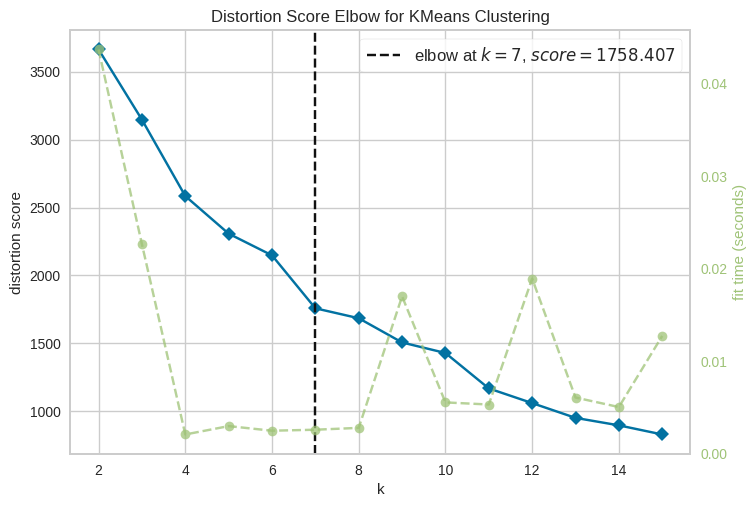

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [8]:
kmeans = KMeans(n_init="auto", random_state=42)
kmeans_visual = KElbowVisualizer(kmeans, k=(2, 16)).fit(X_scaled)
kmeans_visual.show()

In [9]:
kmeans.n_clusters = kmeans_visual.elbow_value_
kmeans = kmeans.fit(X_scaled)

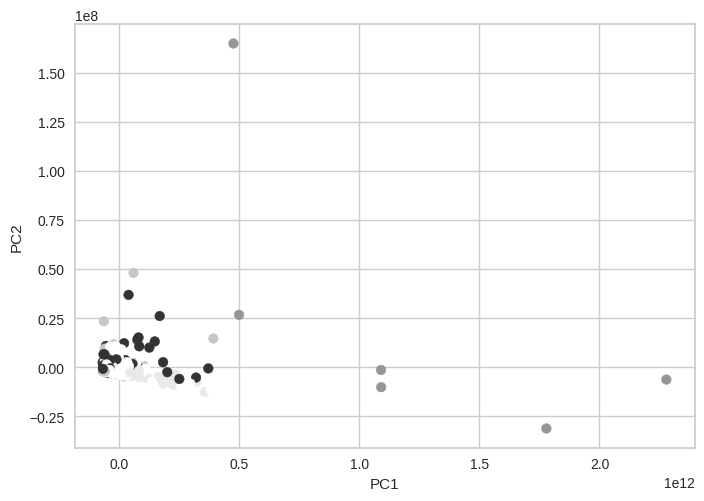

In [10]:
# Reduce the feature space to 2 dimensions using PCA and plot
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

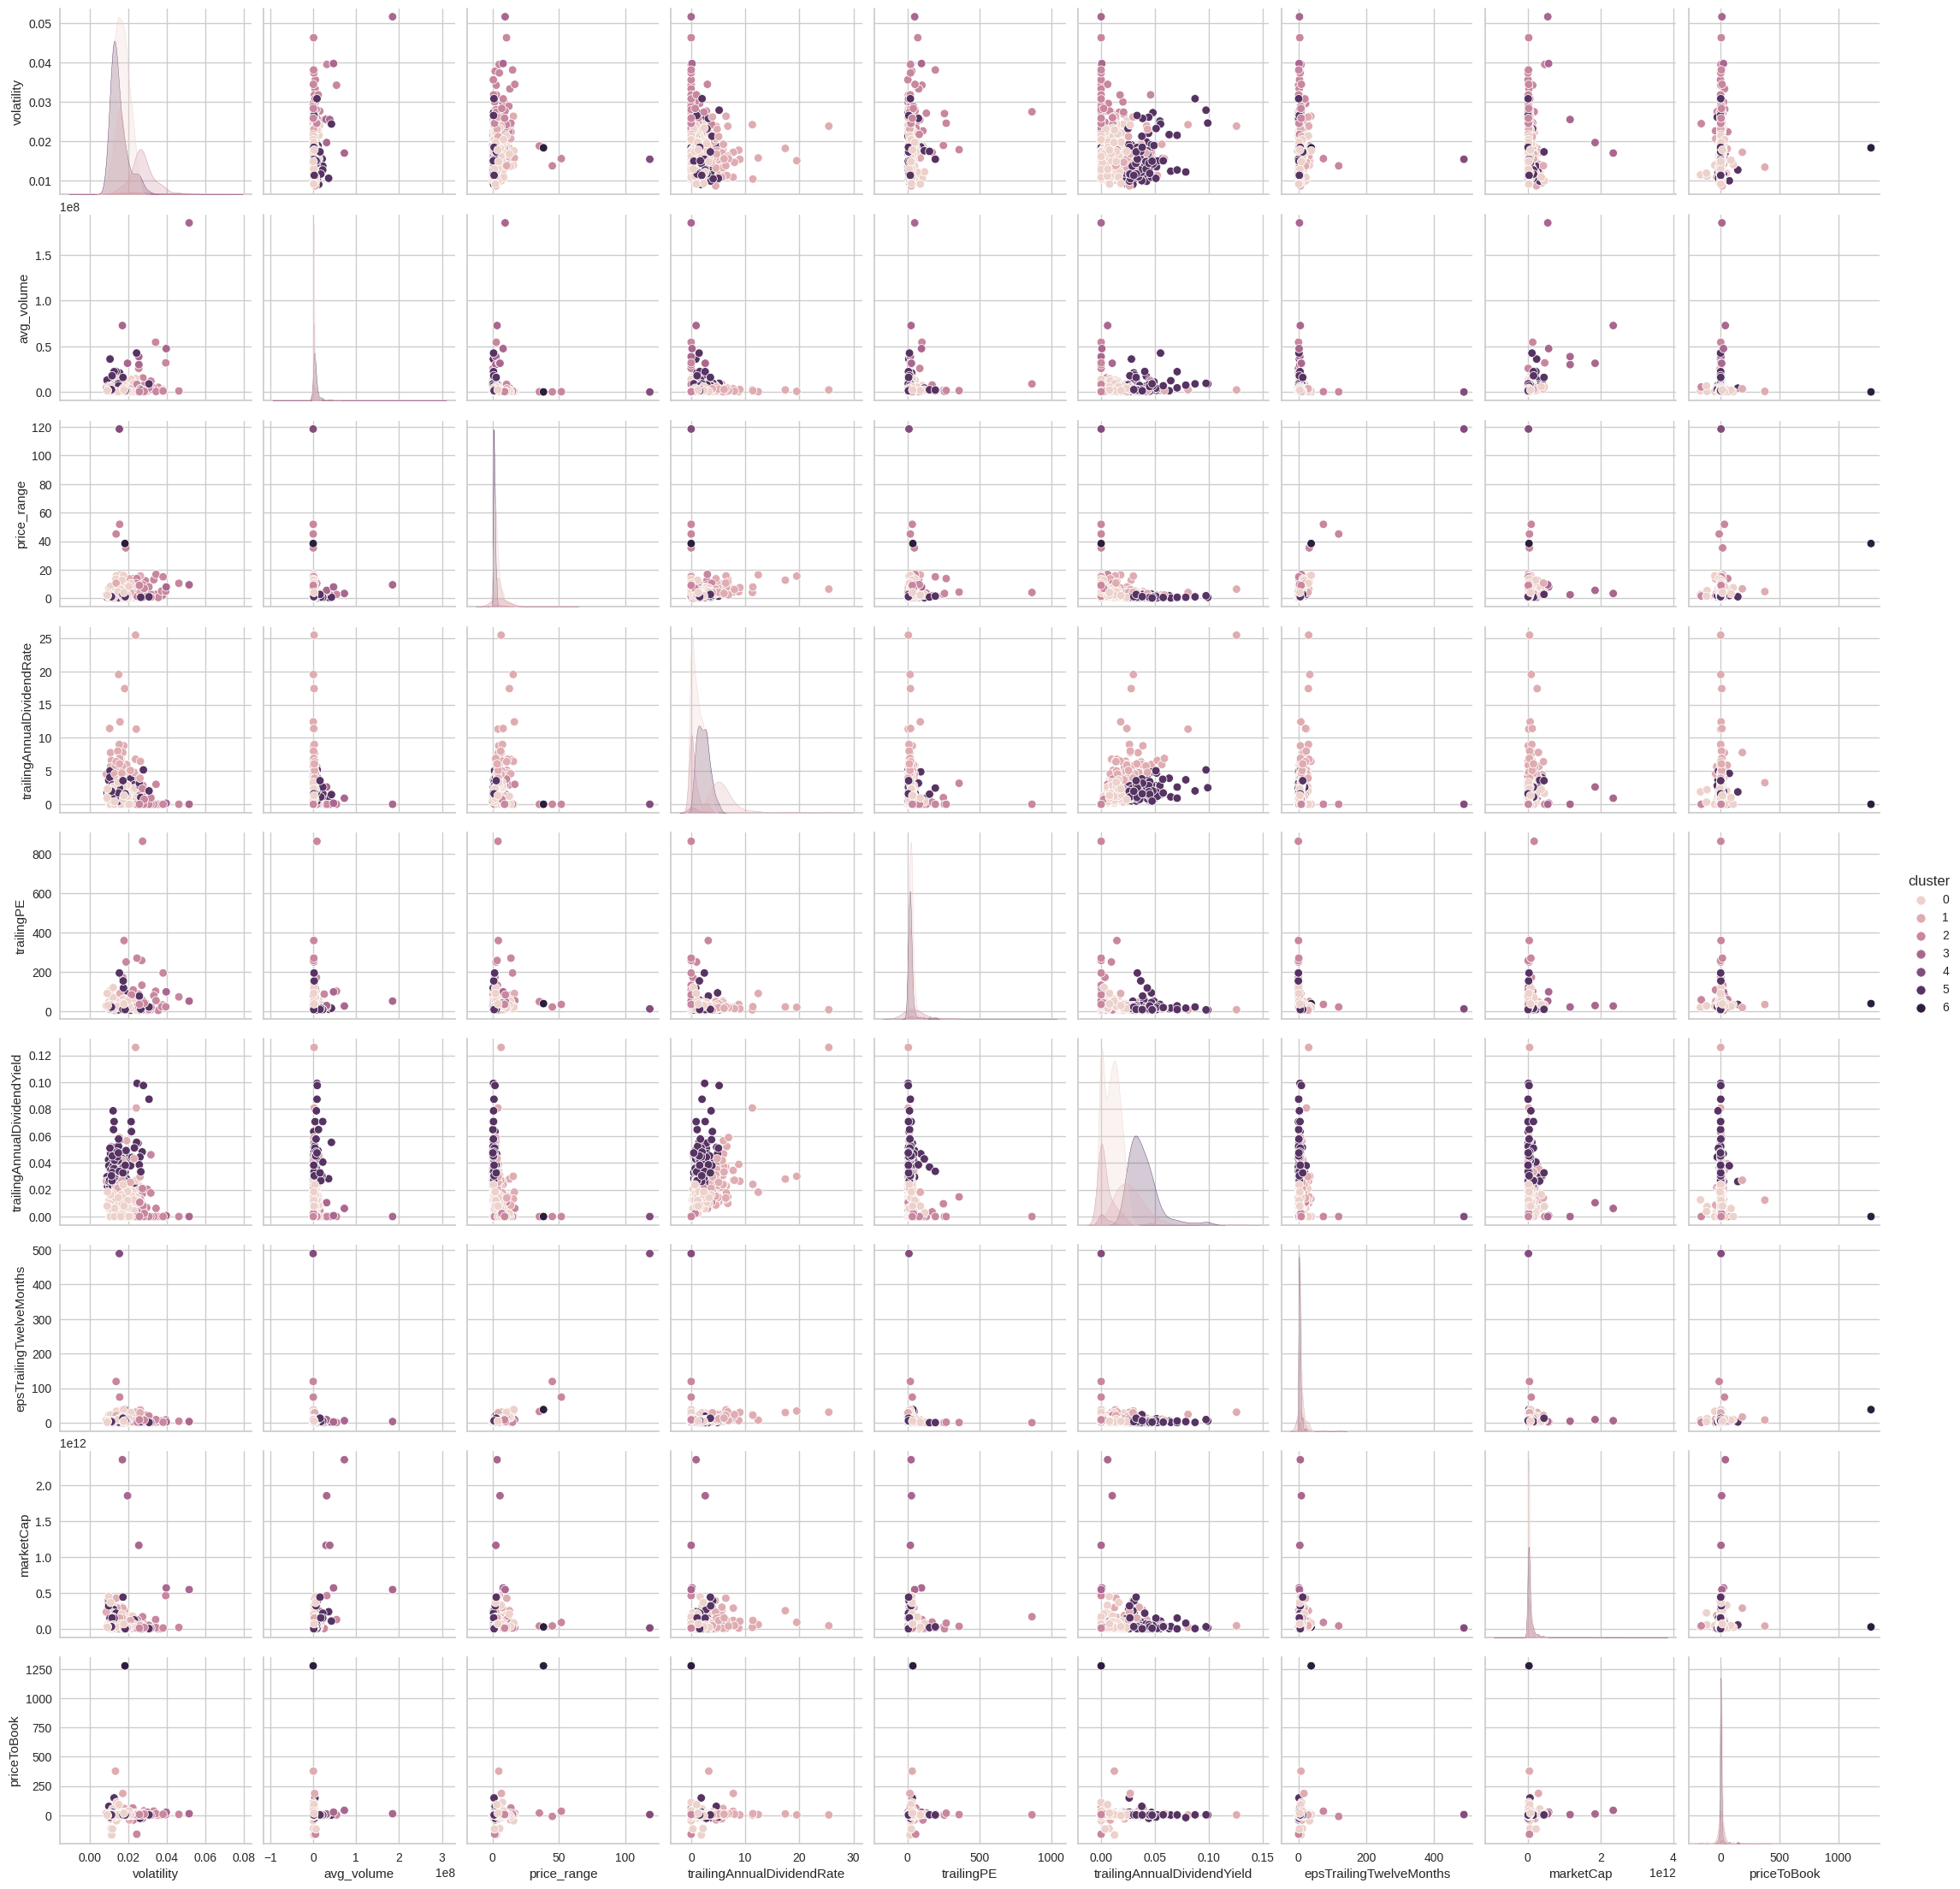

In [11]:
results = features.copy()

# Add the cluster labels to the features DataFrame
results['cluster'] = kmeans.labels_

# Create scatter plots of each pair of variables, colored by cluster label
sns.pairplot(results, vars=results.columns[:-1], hue='cluster')
plt.show()

In [12]:
constant_features = []

min_additional_features = 1
optional_features = list(set(features.columns.tolist()) - set(constant_features))

# Create list of feature combinations to test
combinations_to_test = []
for i in range(min_additional_features, len(optional_features)+1):

    optional_combos = combinations(optional_features, i)
    combinations_to_test.extend(tuple(constant_features) + tuple(opt) for opt in optional_combos)

print(len(combinations_to_test))

511


100%|██████████| 511/511 [03:11<00:00,  2.67it/s]


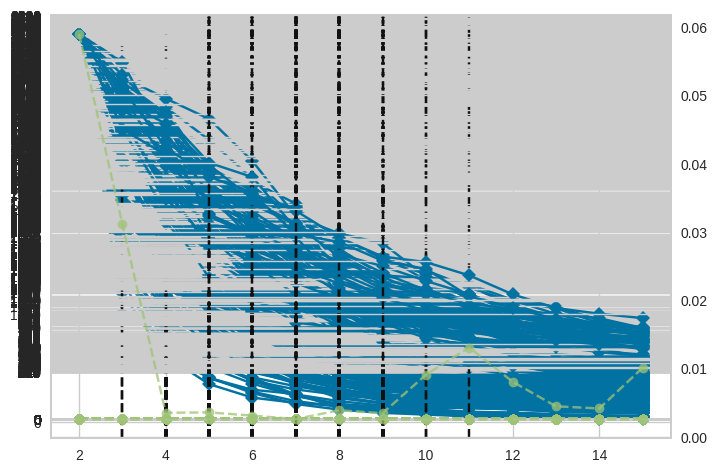

In [28]:
results = []

for combo in tqdm(combinations_to_test):

    X = features[list(combo)].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kmeans = KMeans(n_init="auto", random_state=42)
    kmeans_visual = KElbowVisualizer(kmeans, k=(2, 16)).fit(X_scaled)
    
    kmeans.n_clusters = kmeans_visual.elbow_value_
    kmeans = kmeans.fit(X_scaled)

    # Calculate metrics
    wss = kmeans.inertia_
    ssb = 0 # calc_ssb(kmeans, X_scaled)
    silhouette = silhouette_score(X_scaled, kmeans.labels_)
    
    # add results to dataframe
    results.append({
        'features': list(combo),
        'n_clusters': kmeans.n_clusters,
        'wss': wss,
        'wss_norm': wss / len(combo),
        'ssb': ssb,
        'silhouette': silhouette
    })

results_df = pd.DataFrame(results)

In [29]:
results_df = results_df.sort_values(by='silhouette', ascending=False)
results_df.head()

,features,n_clusters,wss,wss_norm,ssb,silhouette
27,"[epsTrailingTwelveMonths, priceToBook]",3,145.249146,72.624573,0,0.972004
103,"[epsTrailingTwelveMonths, marketCap, priceToBook]",4,274.931253,91.643751,0,0.915106
6,[priceToBook],5,12.010445,12.010445,0,0.907859
159,"[avg_volume, epsTrailingTwelveMonths, marketCa...",5,395.694443,98.923611,0,0.899984
300,"[avg_volume, epsTrailingTwelveMonths, price_ra...",5,581.937199,116.387440,0,0.877653


In [30]:
results_df.to_csv('cluster_results.csv')

In [31]:
model_df = results_df.iloc[4, :]
model_df

features      [avg_volume, epsTrailingTwelveMonths, price_ra...
n_clusters                                                    5
wss                                                  581.937199
wss_norm                                              116.38744
ssb                                                           0
silhouette                                             0.877653
Name: 300, dtype: object

In [33]:
model_features = features.copy()
model_features = model_features[model_df["features"]]

X = model_features.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=model_df["n_clusters"], n_init="auto", random_state=42).fit(X_scaled)

Features: ['avg_volume', 'epsTrailingTwelveMonths', 'price_range', 'marketCap', 'priceToBook']
Silhouette score: 0.8776532876933598
Elbow value: 5
cluster
0    453
2      4
1      1
3      1
4      1
dtype: int64


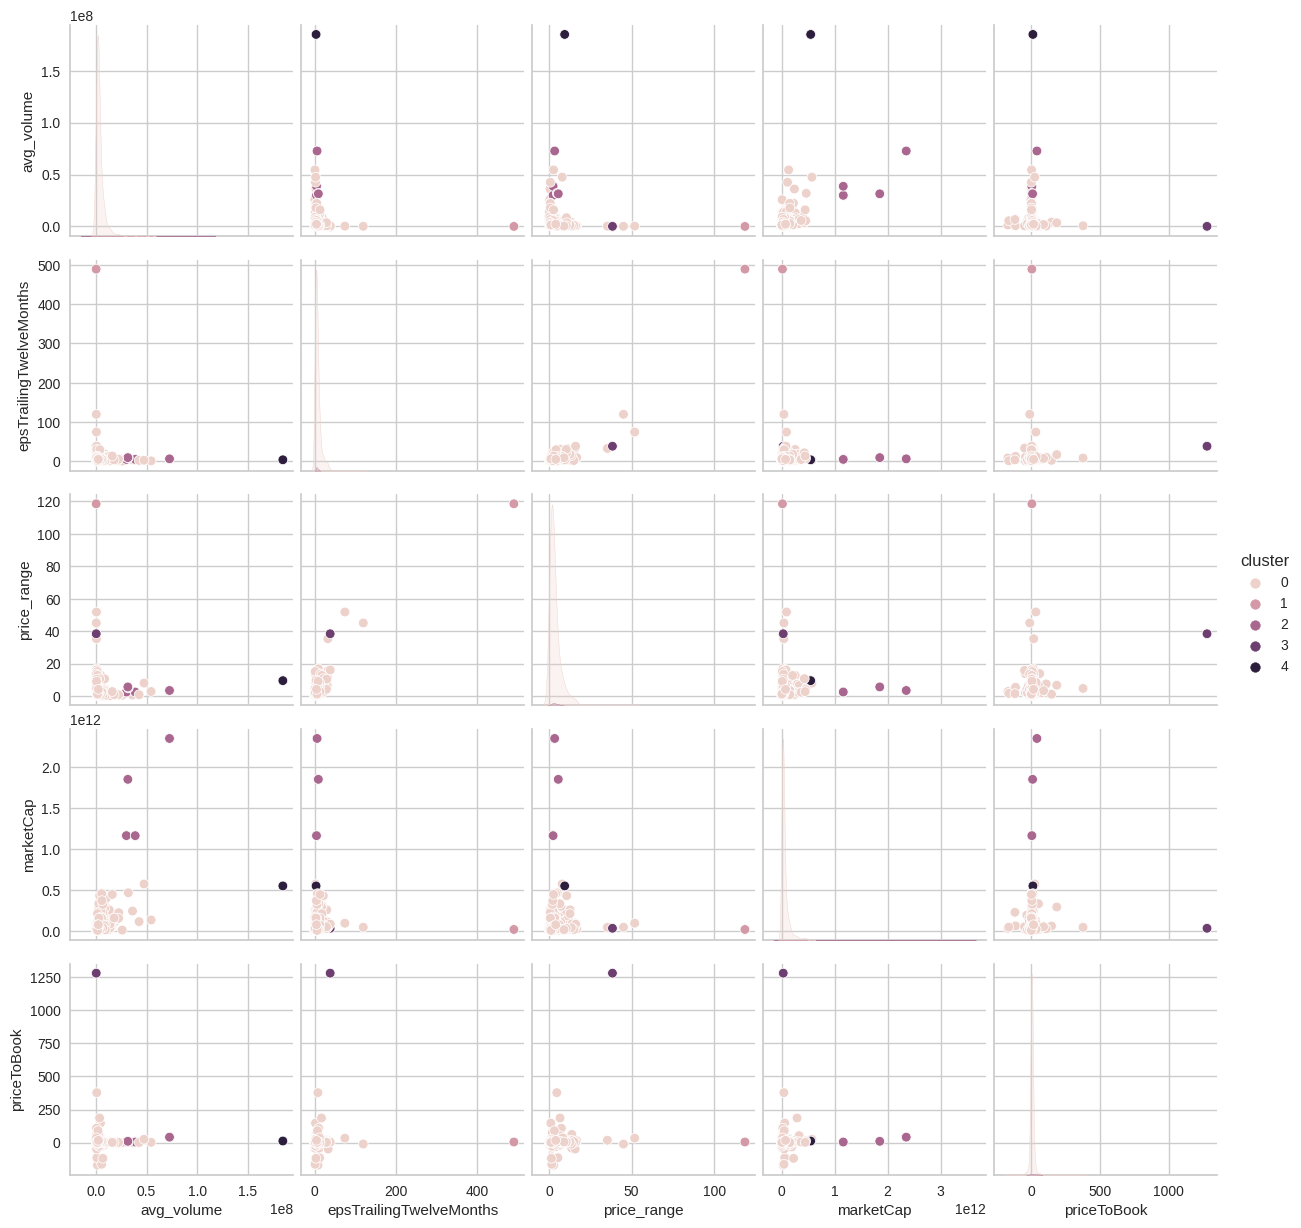

In [39]:
model_results = model_features.copy()

# Add the cluster labels to the features DataFrame
model_results['cluster'] = kmeans.labels_
print(f"Features: {model_df['features']}",  f"Silhouette score: {model_df['silhouette']}", f"Elbow value: {model_df['n_clusters']}", sep="\n")
print(model_results.value_counts('cluster'))

# Create scatter plots of each pair of variables, colored by cluster label
sns.pairplot(model_results, vars=model_df["features"], hue='cluster')
plt.show()

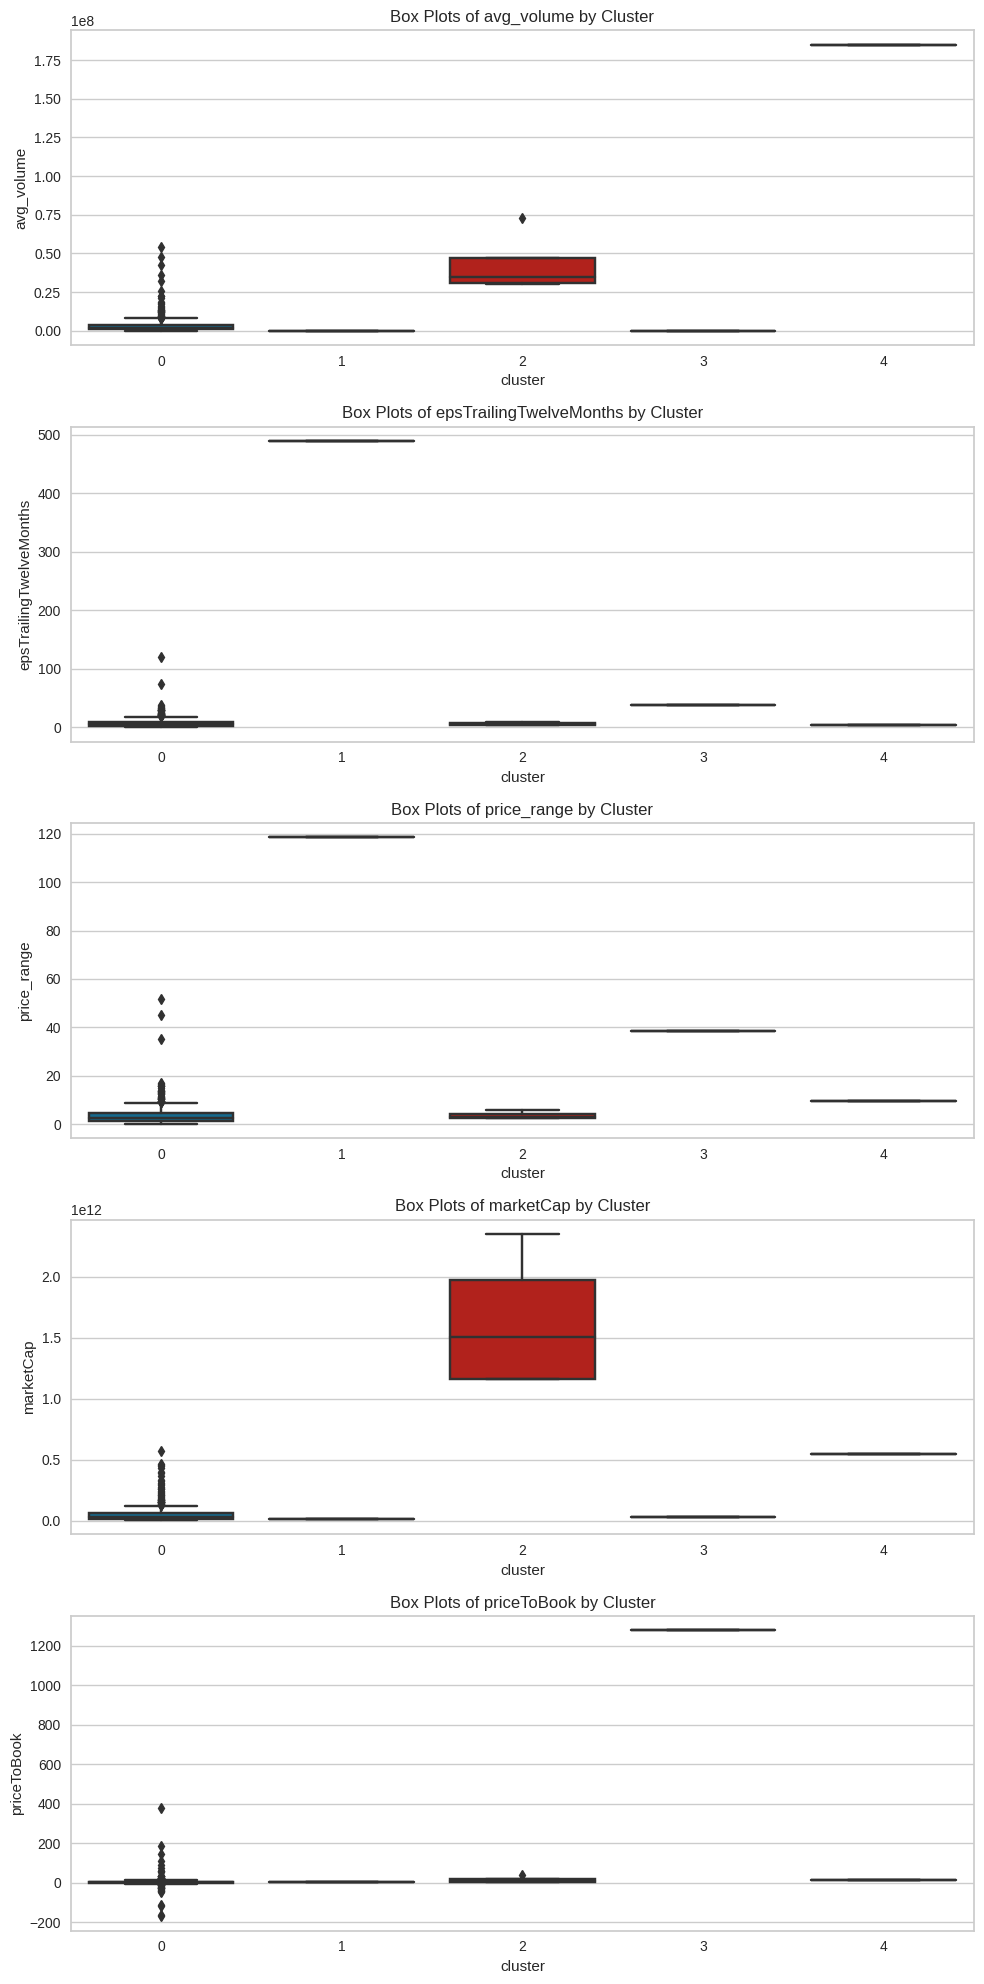

In [37]:
fig, axes = plt.subplots(nrows=len(model_df["features"]), ncols=1, figsize=(10, 20))

for i, feature in enumerate(model_df["features"]):
    sns.boxplot(data=model_results, x='cluster', y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plots of {feature} by Cluster')

plt.tight_layout()
plt.show()

In [41]:
results_df

,features,n_clusters,wss,wss_norm,ssb,silhouette
27,"[epsTrailingTwelveMonths, priceToBook]",3,145.249146,72.624573,0,0.972004
103,"[epsTrailingTwelveMonths, marketCap, priceToBook]",4,274.931253,91.643751,0,0.915106
6,[priceToBook],5,12.010445,12.010445,0,0.907859
159,"[avg_volume, epsTrailingTwelveMonths, marketCa...",5,395.694443,98.923611,0,0.899984
300,"[avg_volume, epsTrailingTwelveMonths, price_ra...",5,581.937199,116.387440,0,0.877653
...,...,...,...,...,...,...
454,"[trailingAnnualDividendRate, trailingPE, price...",10,824.707186,137.451198,0,0.206582
434,"[avg_volume, trailingPE, price_range, priceToB...",8,917.227139,152.871190,0,0.206419
510,"[avg_volume, trailingAnnualDividendRate, epsTr...",7,1758.406629,195.378514,0,0.203957
503,"[avg_volume, trailingAnnualDividendRate, epsTr...",8,1370.497618,171.312202,0,0.197555


Identify which features lead to significant differences in the means between different clusters

In [46]:
from scipy.stats import f_oneway

# loop over each feature and perform ANOVA test
for feature in model_df['features']:
    
    # create a list of series, one for each cluster
    series_list = []
    for cluster in model_results['cluster'].unique():
        cluster_data = model_results[model_results['cluster'] == cluster][feature]
        series_list.append(cluster_data)
    
    # perform ANOVA test
    f_value, p_value = f_oneway(*series_list)
    
    # print results
    print(f"Feature: {feature}")
    print(f"F-value: {f_value:.2f}")
    print(f"P-value: {p_value:.2f}\n")

Feature: avg_volume
F-value: 292.12
P-value: 0.00

Feature: epsTrailingTwelveMonths
F-value: 696.99
P-value: 0.00

Feature: price_range
F-value: 167.20
P-value: 0.00

Feature: marketCap
F-value: 316.30
P-value: 0.00

Feature: priceToBook
F-value: 535.75
P-value: 0.00

